# Mai24_CMLOPS_Accidents_Cdc_#2_Modeles

## 1- Analyse de corrélation de variables

In [1]:
# Import des bibliothèques nécessaires au projet
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import time

# Ignorer les avertissements
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('data 2005a2021.csv', index_col=0)

In [4]:
# colonne non catégorielle
colonne_Non_cat=['num_acc', 'an_nais', "num_veh", 'annee', 'mois', 'jour', 'com', 'dep', 'hr', 'mn','nbv','lartpc','larrout']

# colonne catégorielle
cat_columns = [col for col in df.columns if col not in colonne_Non_cat]

In [5]:
import scipy.stats as stats

# calcul des corrélations pour les variables catégorielles uniquement
cat_corr = {}
for col in cat_columns:
    contingency_table = pd.crosstab(df['grav'], df[col])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    cat_corr[col] = chi2

print("Chi2 avec 'grav':")
print(cat_corr)

Chi2 avec 'grav':
{'lum': 42586.40576514557, 'agg': 89242.82155143883, 'int': 27733.507655346883, 'atm': 5963.580587186945, 'col': 93221.16170445719, 'catv': 102733.36800586228, 'choc': 49738.91297649023, 'manv': 101043.66215875177, 'place': 38465.963033061285, 'catu': 38293.87715526149, 'grav': 4357946.0, 'sexe': 2682.426360463483, 'trajet': 34449.21679522872, 'catr': 102264.44538582121, 'circ': 36994.1938459717, 'prof': 15249.309644481145, 'plan': 36547.93186768001, 'surf': 3357.507010418821, 'situ': 47764.423170739945}


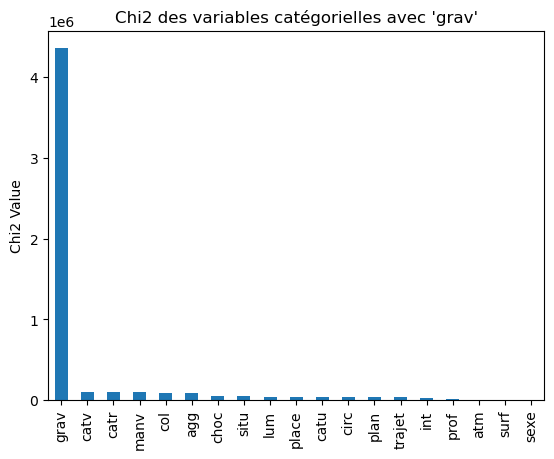

In [6]:
# bar plot pour les résultats du test du chi-carré
cat_corr_series = pd.Series(cat_corr).sort_values(ascending=False)
cat_corr_series.plot(kind='bar')
plt.title("Chi2 des variables catégorielles avec 'grav'")
plt.ylabel('Chi2 Value')
plt.show()

In [7]:
# le nombre de colonnes étant conséquent, nous cherchons à supprimer celles non nécessaires
# les variables atm, annee_y, annee_x, sexe et surf ne semblent pas corrélées avec grav - nous les supprimons donc
colonnes_a_supprimer = ['atm', 'annee', 'sexe', 'surf', "num_veh"]
df = df.drop(columns=colonnes_a_supprimer)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2178973 entries, 200500000001 to 201900058840
Data columns (total 26 columns):
 #   Column   Dtype  
---  ------   -----  
 0   mois     int64  
 1   jour     int64  
 2   lum      int64  
 3   agg      int64  
 4   int      int64  
 5   col      float64
 6   com      int64  
 7   dep      int64  
 8   hr       int64  
 9   mn       int64  
 10  catv     int64  
 11  choc     float64
 12  manv     float64
 13  place    int64  
 14  catu     int64  
 15  grav     int64  
 16  trajet   float64
 17  an_nais  int64  
 18  catr     int64  
 19  circ     float64
 20  nbv      int64  
 21  prof     float64
 22  plan     float64
 23  lartpc   int64  
 24  larrout  int64  
 25  situ     float64
dtypes: float64(8), int64(18)
memory usage: 448.9 MB


In [10]:
len(df)

2178973

In [11]:
df["grav"].value_counts()

grav
1    1669817
3     450462
2      58694
Name: count, dtype: int64

## 2- Préparation du jeu de donnée - pré processing

In [14]:
# on sépare les variables cibles et les caractéristiques
X = df.drop(columns=['grav'])
y = df['grav']

In [15]:
# on divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# nous avons vu dans notre analyse de données que les classes 2 et 3 étaient sous représentées

# afin de régler ce déséquilibre de classe, nous allons faire un SMOTE et l'appliquer à nos données
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [17]:
#print('Classes échantillon smote :', dict(pd.Series(y_train_resampled).value_counts()))
#le nombre de l'échantillon a augmenté (environ 4M)
#Classes échantillon smote : {1: 1335601, 3: 1335601, 2: 1335601}
#il vaut mieux utiliserla méthode de RandomUnderSampler

In [30]:
ru =RandomUnderSampler()
X_train_resampled, y_train_resampled = ru.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_resampled).value_counts()))

Classes échantillon undersampled : {1: 46839, 2: 46839, 3: 46839}


## 3- Entrainement de plusieurs modèles

In [33]:
# entrainement d un arbre de decision

model_tree_clf = DecisionTreeClassifier(random_state=42, max_depth=10)

start_time = time.time()
model_tree_clf.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

training_time = end_time - start_time
print(f"Temps d'entraînement du modèle : {training_time:.2f} secondes")

y_pred = model_tree_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Temps d'entraînement du modèle : 0.72 secondes
Confusion Matrix:
[[229890  36627  67699]
 [  1431   7711   2713]
 [ 20770  30338  38616]]

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.69      0.78    334216
           2       0.10      0.65      0.18     11855
           3       0.35      0.43      0.39     89724

    accuracy                           0.63    435795
   macro avg       0.46      0.59      0.45    435795
weighted avg       0.78      0.63      0.69    435795


Accuracy Score:
0.6338232425796533


In [35]:
# entrainement d un random forest

model_rf_clf = RandomForestClassifier(random_state=42)

start_time = time.time()
model_rf_clf.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

training_time = end_time - start_time
print(f"Temps d'entraînement du modèle : {training_time:.2f} secondes")

y_pred = model_rf_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Temps d'entraînement du modèle : 28.86 secondes
Confusion Matrix:
[[234242  34413  65561]
 [   962   8304   2589]
 [ 19301  30289  40134]]

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.70      0.80    334216
           2       0.11      0.70      0.20     11855
           3       0.37      0.45      0.41     89724

    accuracy                           0.65    435795
   macro avg       0.47      0.62      0.47    435795
weighted avg       0.79      0.65      0.70    435795


Accuracy Score:
0.6486536100689544


In [36]:
# nous souhaitons un modele predisant mieux les gravites eleves,
# on sauvegarde donc le modele avec la meilleure
import joblib
with open('model_rf_clf.pkl', 'wb') as file:
    joblib.dump(model_rf_clf, file)